In [17]:
from datasets import load_dataset

dataset = load_dataset("Arkan0ID/furniture-dataset")

Resolving data files:   0%|          | 0/1493 [00:00<?, ?it/s]

In [18]:
dataset= load_dataset("byliu/DeepFurniture", split="train")

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

In [25]:
import torch
import numpy as np
from torchvision import models, transforms
from datasets import load_dataset
from torch.utils.data import IterableDataset, DataLoader
from PIL import Image
import os

# Image transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Streaming Dataset
class StreamingFurnitureDataset(IterableDataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        self.image_key = 'image' if 'image' in next(iter(dataset)) else 'jpg'

    def __iter__(self):
        for sample in self.dataset:
            image = sample.get(self.image_key)
            if image is None:
                continue
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = self.transform(image)
            yield image

# Load streaming dataset
dataset_stream = load_dataset("byliu/DeepFurniture", split="train", streaming=True)
torch_dataset = StreamingFurnitureDataset(dataset_stream, image_transform)
dataloader = DataLoader(torch_dataset, batch_size=256, num_workers=6, pin_memory=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

# Use fp16 on supported GPUs
use_fp16 = False
if device.type == "cuda":
    model = model.half()
    use_fp16 = True

# Extract and save embeddings in chunks
def extract_and_save_streaming_embeddings(dataloader, save_path="hf_furniture_dataset_embeddings.npz", chunk_size=5120):
    os.makedirs("chunks", exist_ok=True)
    chunk_id = 0
    current_chunk = []

    with torch.no_grad():
        total_images = 0
        for i, batch in enumerate(dataloader):
            if use_fp16:
                batch = batch.to(device, dtype=torch.float16, non_blocking=True)
            else:
                batch = batch.to(device)
            emb = model(batch).squeeze(-1).squeeze(-1).cpu().numpy()
            current_chunk.append(emb)
            total_images += emb.shape[0]
            print(f"Processed {total_images} images")

            if total_images % chunk_size == 0:
                chunk_arr = np.concatenate(current_chunk, axis=0)
                np.savez_compressed(f"chunks/chunk_{chunk_id}.npz", embeddings=chunk_arr)
                print(f"Saved chunk {chunk_id} with shape {chunk_arr.shape}")
                current_chunk = []
                chunk_id += 1

        # Save any remaining embeddings
        if current_chunk:
            chunk_arr = np.concatenate(current_chunk, axis=0)
            np.savez_compressed(f"chunks/chunk_{chunk_id}.npz", embeddings=chunk_arr)
            print(f"Saved final chunk {chunk_id} with shape {chunk_arr.shape}")

    # Combine all chunks into one final file (optional)
    all_embeddings = []
    for i in range(chunk_id + 1):
        chunk = np.load(f"chunks/chunk_{i}.npz")["embeddings"]
        all_embeddings.append(chunk)
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Final embedding shape: {all_embeddings.shape}")
    print(f"Saved all embeddings to {save_path}")

# # Run
# print("Extracting and saving embeddings (streaming)...")
# extract_and_save_streaming_embeddings(dataloader)


Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

/home/abhi/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhi/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
test_images = [p for p in image_paths if "test" in p.lower()]
print(f"Found {len(test_images)} image(s) with 'test' in the path.")
for p in test_images:
    print(p)


Found 0 image(s) with 'test' in the path.


In [6]:
import torch
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import os

# Directory containing your local images
image_dir = "furniture_cls_yolo/train"  # <-- Update if needed

# Image transforms (resize, normalize for ResNet)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset from local directory using ImageFolder
dataset = datasets.ImageFolder(root=image_dir, transform=image_transform)

# Save original image paths for indexing later
image_paths = [path for path, _ in dataset.samples]

# DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ResNet50 feature extractor setup
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final classifier
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract embeddings
def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in dataloader:  # unpack tuple: images and labels
            images = images.to(device)
            emb = model(images).squeeze(-1).squeeze(-1)  # [B, 2048]
            embeddings.append(emb.cpu())
    return torch.cat(embeddings)


# print("Extracting embeddings from furniture_cls_yolo...")
# dataset_embeddings = extract_embeddings(dataloader).numpy()
# print(f"Embedding shape: {dataset_embeddings.shape}")

# # Save embeddings and image paths
# np.savez_compressed("yolo_furniture_embeddings.npz", embeddings=dataset_embeddings, paths=np.array(image_paths))
# print("Saved embeddings and image paths to yolo_furniture_embeddings.npz")


/home/abhi/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhi/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch
data = np.load("hf_furniture_dataset_embeddings.npz")
dataset_embeddings = torch.tensor(data["embeddings"])  # shape [N, 2048]

# Function to embed a test image
def embed_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(device)

    # Cast input to match model's dtype
    image = image.to(dtype=next(model.parameters()).dtype)

    with torch.no_grad():
        embedding = model(image).squeeze().cpu()
    return embedding


# Function to find top K similar images
def find_similar_images(test_embedding, dataset_embeddings, k=5):
    # Convert to same dtype (float32)
    test_embedding = test_embedding.to(dtype=torch.float32)
    dataset_embeddings = dataset_embeddings.to(dtype=torch.float32)

    # Normalize
    test_embedding = test_embedding / test_embedding.norm()
    dataset_embeddings = dataset_embeddings / dataset_embeddings.norm(dim=1, keepdim=True)

    # Compute cosine similarity
    similarities = torch.matmul(dataset_embeddings, test_embedding)
    topk_indices = torch.topk(similarities, k).indices
    return topk_indices

# Function to display images
def show_images(indices, test_image_path):
    plt.figure(figsize=(15, 5))
    
    # Show test image first
    test_img = Image.open(test_image_path).convert("RGB")
    plt.subplot(1, len(indices) + 1, 1)
    plt.imshow(test_img)
    plt.title("Test Image")
    plt.axis("off")

    # Show similar images
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices) + 1, i + 2)

        sample = dataset[idx]
        img = sample["jpg"] if isinstance(sample, dict) and "jpg" in sample else sample

        # Skip or replace if img is None
        if img is None:
            img = np.ones((224, 224, 3), dtype=np.uint8) * 200  # Placeholder gray image
            plt.title(f"Missing Image #{i+1}")
        else:
            if isinstance(img, Image.Image):
                img = np.array(img.convert("RGB"))
            plt.title(f"Similar #{i+1}")
        
        print(f"Index {idx}: type = {type(img)}")
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Index 5589: type = <class 'numpy.ndarray'>
Index 14110: type = <class 'numpy.ndarray'>
Index 8345: type = <class 'numpy.ndarray'>
Index 24669: type = <class 'numpy.ndarray'>
Index 8338: type = <class 'numpy.ndarray'>


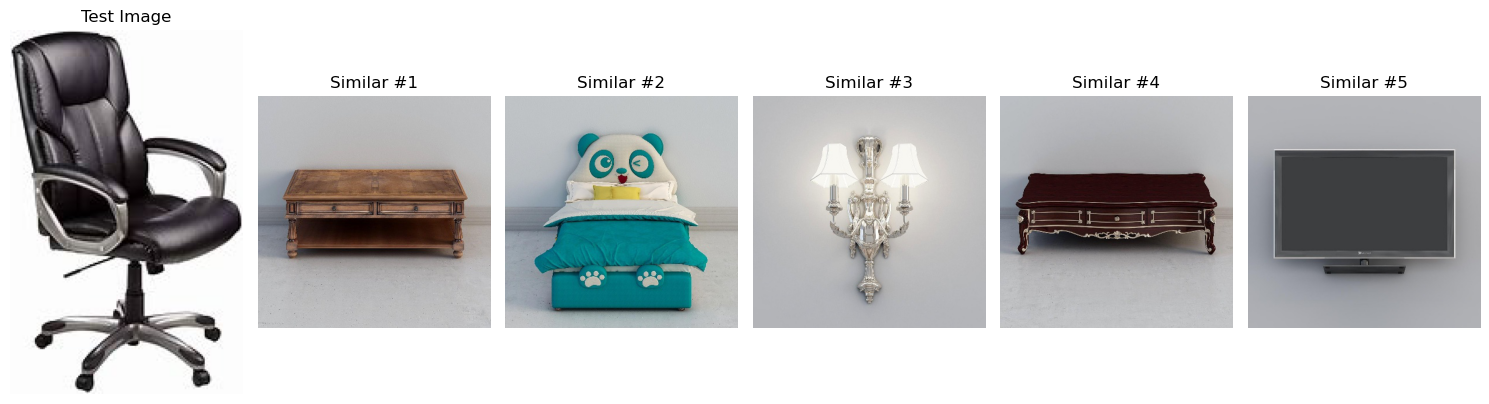

In [46]:
# ---- MAIN USAGE ----
# Replace with your test image path
from PIL import Image
test_image_path = "furniture_cls_yolo/val/chair/chair_val_34.jpeg"

test_embedding = embed_image(test_image_path)
top5_indices = find_similar_images(test_embedding, dataset_embeddings, k=5)
top5_indices = top5_indices.tolist()  # Convert to list of ints
show_images(top5_indices, test_image_path)


In [44]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Load embeddings
data = np.load("yolo_furniture_embeddings.npz")
dataset_embeddings = torch.tensor(data["embeddings"])  # shape [N, 2048]

# Image transform (reuse the same one used for embedding)
from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset (ImageFolder version)
from torchvision.datasets import ImageFolder
dataset = ImageFolder("furniture_cls_yolo/train")  # use the same root path used during embedding

# Model setup (feature extractor)
from torchvision import models
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Embed a test image
def embed_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]
    with torch.no_grad():
        embedding = model(image).squeeze().cpu()  # [2048]
    return embedding

# Find top-K similar images
def find_similar_images(test_embedding, dataset_embeddings, k=5):
    test_embedding = test_embedding / test_embedding.norm()
    dataset_embeddings = dataset_embeddings / dataset_embeddings.norm(dim=1, keepdim=True)
    similarities = torch.matmul(dataset_embeddings, test_embedding)  # [N]
    topk_indices = torch.topk(similarities, k).indices
    return topk_indices

# Show images
def show_images(indices, test_image_path):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, len(indices) + 1, 1)
    plt.imshow(Image.open(test_image_path).convert("RGB"))
    plt.title("Test Image")
    plt.axis("off")
    
    for i, idx in enumerate(indices.tolist()):
        image_path, _ = dataset.imgs[idx]  # get original path from ImageFolder
        plt.subplot(1, len(indices) + 1, i + 2)
        plt.imshow(Image.open(image_path).convert("RGB"))
        plt.title(f"Similar #{i + 1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


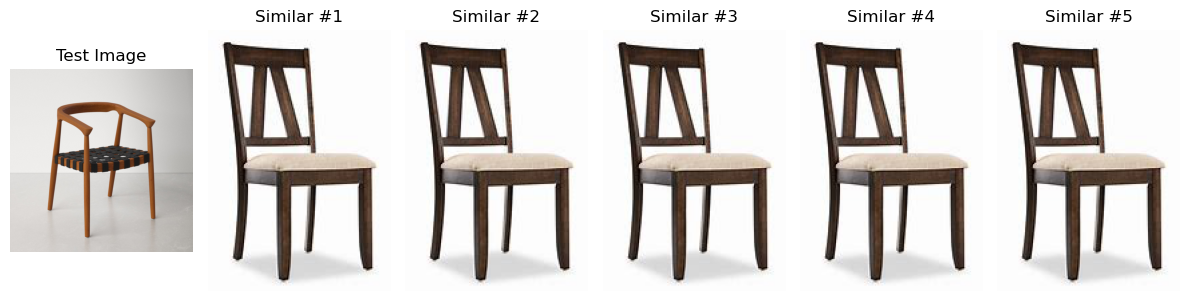

In [45]:
test_path = "sample_image_90.jpg"
test_emb = embed_image(test_path)
topk = find_similar_images(test_emb, dataset_embeddings, k=5)
show_images(topk, test_path)


In [38]:
from PIL import Image

# Get the image
image = dataset['train'][90]['image']

# Ensure it's a PIL image
if not isinstance(image, Image.Image):
    image = Image.fromarray(image)

# Save it to disk
image.save("sample_image_90.jpg")
print("Image saved as sample_image_90.jpg")


Image saved as sample_image_90.jpg


{'BMP': <function PIL.BmpImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes', bitmap_header: 'bool' = True) -> 'None'>,
 'DIB': <function PIL.BmpImagePlugin._dib_save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes') -> 'None'>,
 'GIF': <function PIL.GifImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes', save_all: 'bool' = False) -> 'None'>,
 'JPEG': <function PIL.JpegImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes') -> 'None'>,
 'PPM': <function PIL.PpmImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes') -> 'None'>,
 'PNG': <function PIL.PngImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes', chunk: 'Callable[..., None]' = <function putchunk at 0x73f82e5e0a40>, save_all: 'bool' = False) -> 'None'>,
 'BLP': <function PIL.BlpImagePlugin._save(im: 'Image.Image', fp: 'IO[bytes]', filename: 'str | bytes') -> 'None'>,
 'BUFR': <function PIL.BufrStu